In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from timeit import default_timer as timer
import time
from IPython import display
import math
from matplotlib.pyplot import figure
from jupyterthemes import jtplot
from matplotlib import rcParams
rcParams['axes.labelpad'] = 20
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# Definicja funkcji

In [2]:
# Aktualizacja funkcji f:
def Updatef(f, cx, cy):
    for i, cx_i, cy_i in zip(range(9), cx, cy):
        f[:,:,i] = np.roll(f[:,:,i], cx_i, axis=1)
        f[:,:,i] = np.roll(f[:,:,i], cy_i, axis=0)
    return f


# Funkcja wyznaczająca gęstość oraz prędkości ux i uy:
def Get_rho_ux_uy(f,cx,cy):
    rho = np.sum(f,2)       # Gęstość
    ux = np.sum(f*cx,2)/rho # Prędkość składowa x
    uy = np.sum(f*cy,2)/rho # Prędkość składowa y
    return rho, ux, uy


# Funkcja równowagi:
def Getfeq(f, tau, Lx, Ly, rho, ux, uy, cx, cy, cs, w):
    feq = np.zeros((Ly,Lx,9))
    for i, cx_i, cy_i, w_i in zip(range(9), cx, cy, w):
        feq[:,:,i] = w_i*rho*(1+(ux*cx_i+uy*cy_i)/(cs**2) + (ux*cx_i+uy*cy_i)**2/(2*cs**4) - (ux*ux+uy*uy)/(2*cs**2))
    return feq



# Propagacja:
def FlowPropagation(f, feq, tau, boundary): 
    f = f*(1-1/tau)+feq*(1/tau)  
    fb = f[boundary,:]
    fb = fb[:,[0,5,6,7,8,1,2,3,4]]
    f[boundary,:] = fb
    return f


# Funkcja wirowości:
def GetVorticity(ux, uy, boundary): 
    vorticity = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1)) # (grad x u), u = (ux,uy)
    vorticity[boundary] = np.nan
    return vorticity



# Dodaje prawy i lewy brzeg
def AddxBoundary(Lx,Ly):
    boundary = np.zeros((Lx,Ly),dtype = bool)
    boundary[:,0] = True
    boundary[:, Ly-1] = True
    return boundary
    
# Dodaje gorny i dolny brzeg
def AddyBoundary(Lx,Ly):
    boundary = np.zeros((Lx,Ly),dtype = bool)
    boundary[0,:] = True
    boundary[Lx - 1, :] = True
    return boundary

 # Dodaje przesuniety o jeden piksel lewy i prawy brzeg (uzyteczne w funkcji MoveTheBall)
def AddxBoundaryMovingBall(Lx,Ly):
    boundary = np.zeros((Lx,Ly),dtype = bool)
    boundary[:,1] = True
    boundary[:, Ly-2] = True
    return boundary
    
# Dodaje przesuniety o jeden piksel gorny i dolny brzeg (uzyteczne w funkcji MoveTheBall)
def AddyBoundaryMovingBall(Lx,Ly): 
    boundary = np.zeros((Lx,Ly),dtype = bool)
    boundary[1,:] = True
    boundary[Lx - 2, :] = True
    return boundary



#Tworzy brzeg w postaci kuli o srodku w (wspx,wspy) i promieniu r
def BoundaryBall(wspx,wspy,r,Lx,Ly):
    dist = np.zeros(shape=(Lx,Ly)) #Macierz odleglosci euklidesowych punktow siatki Lx x Ly od srodka kuli
    for x in range(Lx):
        for y in range(Ly):
            X = np.array([x-wspx,y-wspy])
            dist[x,y] = np.linalg.norm(X)
            
    boundary = np.zeros(shape=(Lx,Ly), dtype=bool)  
    for x in range(Lx):
        for y in range(1,Ly-1):
            if dist[x,y]<r: #(x,y) jest elementem kuli dokladnie wowczas gdy odleglosc (x,y) od (wspx,wspy) jest mniejsza od r
                boundary[x,y] = True 
            else:
                boundary[x,y] = False
    return boundary


#Funkcja porszuajaca kula, ktora przemieszcza sie z predkoscia (Sx,Sy) = (+-1,+-1)
def MoveTheBall(ball_position,boundary,Sx,Sy,Lx,Ly):
    boundary_new = np.zeros(shape=(Lx,Ly), dtype=bool)
    nonzeroind = np.nonzero(ball_position&boundary)[0]
    if nonzeroind.size != 0: #Sprawdzamy czy kula zetknela sie z jakims elementem brzegu
        if IsImpactOnXAxis(ball_position,boundary,Sx,Lx,Ly): #Czy zetknela sie od strony X-owej
            Sx=-Sx #jezeli tak to odbij kule wzgledem osi OX
        if IsImpactOnYAxis(ball_position,boundary,Sy,Lx,Ly): #Czy zetknela sie od strony Y-owej
            Sy=-Sy #jezeli tak to odbij kule wzgledem osi OY
    for x in range(1,Lx-1):
        for y in range(1,Ly-1):
            boundary_new[x,y] = bool(True*ball_position[x-Sx,y-Sy]) #aktualizacja pozycji kuli

    return boundary_new,Sx,Sy




In [3]:
#Funkcja sprawdzajaca czy kula zetknela sie z brzegiem od strony X-owej
def IsImpactOnXAxis(ball_position,boundary,Sx,Lx,Ly): 
    answer = False
    boundary_new = np.zeros(shape=(Lx,Ly), dtype=bool)
    for x in range(1,Lx-1):
        for y in range(1,Ly-1):
            boundary_new[x,y] = bool(True*ball_position[x+Sx,y]) #Czy jezeli cofniemy kule wzgledem osi OX to dalej bedzie stykala sie z brzegiem
    if (np.nonzero(boundary_new&boundary)[0]).size == 0:
        answer = True
    return answer
    
#Funkcja sprawdzajaca czy kula zetknela sie z brzegiem od strony Y-owej
def IsImpactOnYAxis(ball_position,boundary,Sy,Lx,Ly):
    answer = False
    boundary_new = np.zeros(shape=(Lx,Ly), dtype=bool)
    for x in range(1,Lx-1):
        for y in range(1,Ly-1):
            boundary_new[x,y] = bool(True*ball_position[x,y+Sy]) #Czy jezeli cofniemy kule wzgledem osi OY to dalej bedzie stykala sie z brzegiem
    if (np.nonzero(boundary_new&boundary)[0]).size == 0:
        answer = True
    return answer


# Pojedynczy krok czasowy:
def TimeStep(f, tau, cx, cy, Lx, Ly, boundary):
    f              = Updatef(f, cx, cy)
    rho, ux, uy    = Get_rho_ux_uy(f,cx,cy)
    feq            = Getfeq(f, tau, Lx, Ly, rho, ux, uy, cx, cy, cs, w)
    f              = FlowPropagation(f, feq, tau, boundary)
    ux[boundary]   = 0
    uy[boundary]   = 0
    vorticity      = GetVorticity(ux, uy, boundary)
    return f, rho, ux, uy,  feq, vorticity


# Funkcja główna - propagacja kroku czasowego:
def MainFunction(Lx,Ly,Lt):
    
    X, Y = np.meshgrid(range(Lx), range(Ly))
    
    # Warunek początkowy na f:
    f = np.ones((Ly,Lx,9))
    f[:,:,3] += 2 * (1+0.2*np.cos(2*np.pi*X/Lx*4))
    rho = np.sum(f,2)
    for i in range(9):
        f[:,:,i] *= rho0/rho

    
    # Implementacja warunków brzegowych (przeszkód):
    boundary = np.zeros((Ly,Lx), dtype = bool)
    boundary1 = np.zeros((Ly,Lx), dtype = bool)
    boundary2 = np.zeros((Ly,Lx), dtype = bool)
    boundary3 = np.zeros((Ly,Lx), dtype = bool)
    boundary4 = np.zeros((Ly,Lx), dtype = bool)
    if start ==1: # Możliwość wyboru przeszkód przez użytkownika
        if figure == 1: 
            Nf = int(input("Liczba przeszkód: "))
            for i in range(Nf):
                boundary += BoundaryBall(int(input("Y_" + str(i+1) + ": ")),
                             int(input("X_" + str(i+1) + ": ")),
                             int(input("r_" + str(i+1) + ": ")),
                             Ly,
                             Lx)

        if figure == 3:
            boundary2 = BoundaryBall(int(input("Współrzędna Y środka poruszającej się kuli: ")),
                                         int(input("Współrzędna X środka poruszającej się kuli: ")),
                                         int(input("Promień poruszającej się kuli: ")),
                                         Ly,
                                         Lx)
            Nf = int(input("Liczba przeszkód: "))
            for i in range(Nf):
                boundary1 += BoundaryBall(int(input("Y_" + str(i+1) + ": ")),
                                         int(input("X_" + str(i+1) + ": ")),
                                         int(input("r_" + str(i+1) + ": ")),
                                         Ly,
                                         Lx)

                boundary3 = AddyBoundary(Ly,Lx) + AddxBoundary(Ly,Lx)
                boundary4 = AddxBoundaryMovingBall(Ly,Lx) + AddyBoundaryMovingBall(Ly,Lx)
    if start ==0: # Przykładowy zestaw przeszkód 
        if figure == 1: 
            boundary += BoundaryBall(20,20,5,Ly,Lx)
            boundary += BoundaryBall(40,50,5,Ly,Lx)
            boundary += BoundaryBall(100,250,20,Ly,Lx)
            boundary += BoundaryBall(90,240,10,Ly,Lx)
            boundary += BoundaryBall(60,150,15,Ly,Lx)
            boundary += BoundaryBall(80,150,10,Ly,Lx)
            
        if figure == 3:
            boundary2 = BoundaryBall(50,50,5,Ly,Lx)
            boundary1 += BoundaryBall(15,15,10,Ly,Lx)
            boundary1 += BoundaryBall(70,150,15,Ly,Lx)
            boundary1 += BoundaryBall(30,120,15,Ly,Lx)
            boundary3 = AddyBoundary(Ly,Lx) + AddxBoundary(Ly,Lx)
            boundary4 = AddxBoundaryMovingBall(Ly,Lx) + AddyBoundaryMovingBall(Ly,Lx)
        
        
    # Główna pętla propagująca czas: 
    time1 = timer()
    TimePropagation = [] 
    if figure == 1:
        for t in range(Lt):
            f, rho, ux, uy,  feq, vorticity = TimeStep(f, tau, cx, cy, Lx, Ly, boundary)
            TimePropagation.append(vorticity.copy())
            Progress = 'Wykonano ' + str(round(100*(t/Lt))) +' %'
            print(Progress, end="\r")
            
    if figure == 3:
        sx = -1 
        sy = -1
        for t in range(Lt):
            f, rho, ux, uy,  feq, vorticity = TimeStep(f, tau, cx, cy, Lx, Ly, boundary1|boundary2|boundary3)
            TimePropagation.append(vorticity.copy())
            boundary2, sy, sx = MoveTheBall(boundary2,boundary1|boundary4,sy,sx,Ly,Lx)
            Progress = 'Wykonano ' + str(round(100*(t/Lt))) +' %'
            print(Progress, end="\r")
    time2 = timer()
    print("Czas wykonania:: " + str(time2 - time1) + " s")
    
    return TimePropagation

# Wykonanie funkcji dla wybranych parametrów

In [4]:
# Wykonanie funkcji dla wybranych parametrów:


cs   = 1/np.sqrt(3)  # Prędkość dźwięku
rho0 = 100           # Gęstość początkowa
tau  = 0.6           # Czas trwania kolizji



# Definicja siatki oraz tabeli dla prędkości i ich wag:

cx   = np.array([0, 0, 1, 1, 1, 0,-1,-1,-1])               # Dyskretne prędkości w kierunku x 
cy   = np.array([0, 1, 1, 0,-1,-1,-1, 0, 1])               # Dyskretne prędkości w kierunku y
w    = np.array([4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]) # Wagi 


start = int(input("Chcę samemu wpisywać dane (1/0): "))
figure = int(input("Typ przeszkody (1 - Koło, 3 - Zamknięta puszka z poruszającą się kulą i przeszkodami): ")) 

if start == 1:
    Lx = int(input("Liczba kroków na siatce w kierunku x: "))
    Ly = int(input("Liczba kroków na siatce w kierunku y: "))
    Lt = int(input("Liczba kroków czasowych: "))
elif start == 0 and figure == 3:
    Lx = 200
    Ly = 90
    Lt = 700
    DT = 3
    DXY = 35
elif start == 0 and figure != 3:
    Lx = 300
    Ly = 120
    Lt = 2500
    DT = 30
    DXY = 50
TimePropagation = MainFunction(Lx,Ly,Lt)

Chcę samemu wpisywać dane (1/0):  0
Typ przeszkody (1 - Koło, 3 - Zamknięta puszka z poruszającą się kulą i przeszkodami):  1


Czas wykonania:: 57.023119699999995 s


# Animacja

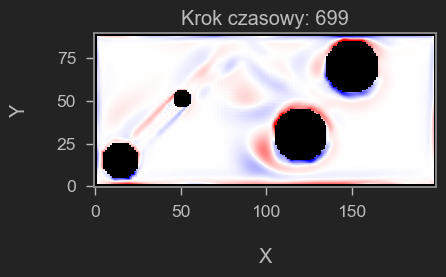

In [6]:
for t in range(Lt):
    if ((t % 20) == 0) or (t == Lt - 1):
        fig = plt.figure(figsize=(int(Lx/DXY),int(Ly/DXY)), dpi=100)
        cmap = plt.cm.bwr
        cmap.set_bad('black')
        plt.imshow(TimePropagation[t], cmap='bwr')
        plt.clim(-.1, .1)
        ax = plt.gca()
        ax.invert_yaxis()
        ax.set_aspect('equal',)
        plt.xlabel("X")
        plt.ylabel("Y")
        ax.set_title("Krok czasowy: " + str(t))
        display.clear_output(wait=True)
        plt.pause(0.00001)